# $\gamma$-Ray Spectra from the Decay of Mesons

## Boosting Spectra

Often it is easiest to evaluate the energy spectrum of a particle $f$, $dN_{I\to f + X}/dE_{f}$, produced in the decay of a state $I$ from the process $I \to f + X$ in 
the rest frame of the decaying state $I$. It is of interest to have to spectrum when the decaying state $I$ is boosted. To compute the spectrum in this case, we use the
following.

First, the momentum in the rest frame are:
\begin{align*}
    P^{\mu}_{I,R} &= (M_{I}; 0,0,0)\\
    P^{\mu}_{f,R} &= (E_{R}; \sqrt{1-z_{R}^2}k_{R}, 0, z_{R}k_{R})\\
\end{align*}
and in the boosted frame:
\begin{align*}
    P^{\mu}_{I,L} &= (E_{I}; 0,0, k_{I})\\
    P^{\mu}_{f,L} &= (E_{L}; \sqrt{1-z_{L}^2}k_{L}, 0, z_{L}k_{L})\\
\end{align*}
with $E_{I} = \gamma M_{I}$ and $k_{I} = \gamma\beta M_{I}$. The Lorentz transformation connecting the boosted and rest-frame momenta is:
$\Lambda = \begin{pmatrix} 
    \gamma & 0 & 0 & -\beta\gamma\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    -\beta\gamma & 0 & 0 & \gamma
\end{pmatrix}$
That is, $P^{\mu}_{R} = \Lambda^{\mu}_{\nu}P^{\nu}_{L}$.



given the spectrum $dN/dE$, we write:
\begin{align*}
    d^2N = \frac{d^2N}{dE_{R}dz_{R}}dE_{R}dz_{R}
\end{align*}
where we will use $d^2N/dE_{R}dz_{R} = (1/2) dN/dE_{R}$. Here, $E_{R}$ is the energy of $f$ in the rest-frame and $z_{R} = \cos(\theta_{R})$ is the cosine of the angle
$f$ makes with the $z$-axis. The variables $E_{R}$ and $z_{R}$ can be related to their corresponding values in the boosted values $E_{L}$ and $z_{L}$ from through:
\begin{align*}
    E_{R} &= \gamma (E_{L} - \beta k_{L} z_{L})\\
    k_{R}z_{R} &= \gamma (k_{L}z_{L} - \beta E_{L})
\end{align*}
where $k = \sqrt{E^2 - m_{f}^2}$ is the momentum of $f$. Note that we can change variables to $E_{L}$ and $z_{L}$ using
\begin{align*}
    d^2N = \frac{d^2N}{dE_{R}dz_{R}}dE_{R} dz_{R} = \frac{d^2N}{dE_{R}dz_{R}} J dE_{L} dz_{L}
\end{align*}
where $J$ is the Jacobian. For the case where $f$ is massless, the Jacobian is given by:
\begin{align*}
    J = \frac{1}{\gamma(1-z_{L}\beta)}
\end{align*}
Then, the spectrum in the boosted frame is given by:
\begin{align*}
    \frac{dN}{dE_{L}} &= \int \frac{dz_{L}}{\gamma(1-z_{L}\beta)} \frac{1}{2}\frac{dN}{dE_{R}}(\gamma E_{L}(1-\beta z_{L}))
\end{align*}
If we change variables from $z_{L}$ to $w = 1 - \beta z_{L}$, then this becomes
\begin{align*}
    \frac{dN}{dE_{L}} &= \frac{1}{2\gamma\beta}\int_{1-\beta}^{1+\beta} \frac{dw}{w} \frac{dN}{dE_{R}}(\gamma w E_{L})
\end{align*}

A special case occurs when $dN/dE = A \delta(E - E_{0})$. In this case, we can evaluate the spectrum exactly. The result is:
\begin{align*}
    \frac{dN}{dE_{L}} &= \frac{A}{2\gamma\beta}\int_{1-\beta}^{1+\beta} \frac{dw}{w} \delta(\gamma w E_{L} - E_{0})
    = \frac{A}{2\gamma\beta E_{0}} \left(\theta\left(E_{L} - \frac{E_{0}}{\gamma(1+\beta)}\right) - \theta\left(E_{L} - \frac{E_{0}}{\gamma(1-\beta)}\right)\right)
\end{align*}

## Utilities

In [5]:
from typing import Optional, List, Union
from abc import ABCMeta, abstractmethod

from scipy.interpolate import UnivariateSpline
from scipy import integrate
from scipy import special
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt

from hazma.parameters import eta_mass as meta
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import charged_pion_mass as mpi
from hazma.parameters import neutral_kaon_mass as mk0
from hazma.parameters import charged_kaon_mass as mk
from hazma.parameters import muon_mass as mmu
from hazma.parameters import electron_mass as me
from hazma.rambo import generate_phase_space

from hazma.decay import neutral_pion as dnde_photon_pi0
from hazma.decay import charged_pion as dnde_photon_pi
from hazma.decay import muon as dnde_photon_muon

In [2]:
RealArray = npt.NDArray[np.float64]

In [21]:
class SpectrumBase(metaclass=ABCMeta):

    @abstractmethod
    def boost(self, xs: RealArray, beta: float):
        pass


class SpectrumLine(SpectrumBase):
    """
    Class for working with δ-function spectra.

    Attributes
    ----------
    e0: float
        Energy of the line.
    norm: float
        Normaliztion of the δ-function spectrum.

    Methods
    -------
    boost(es, beta)
        Boost the spectrum by boost factor
    """

    def __init__(self, eloc: float, norm: float) -> None:
        self.eloc: float = eloc
        self.norm: float = norm

    def boost(self, es: RealArray, beta: float):
        dndes = np.zeros_like(es)
        g = 1 / np.sqrt(1 - beta**2)
        ep = self.eloc / (g * (1 - beta))
        em = self.eloc / (g * (1 - beta))
        if beta >= 0.0 or beta <= 1.0:
            dndes = np.where(
                np.logical_and(em < es, es < ep),
                self.norm / (2 * beta * g * self.eloc),
                0.0,
            )
        return Spectrum(es, dndes)


class Spectrum:
    def __init__(
        self, es: RealArray, dndes: RealArray, lines: Optional[Union[SpectrumLine, List[SpectrumLine]]] = None
    ):
        self._es: RealArray = es
        self._dndes: RealArray = dndes
        self._spline = self.__make_spline()

        self._lines: List[SpectrumLine]
        if lines is not None:
            if isinstance(lines, list):
                self._lines = lines
            else:
                self._lines = [lines]
        else:
            self._lines = []

    def __make_spline(self):
        spline = UnivariateSpline(self._es, self._dndes, s=0, k=1, ext=1)
        return spline

    def __call__(self, x):
        return self._spline(x)

    @property
    def es(self):
        return self._es

    @property
    def dndes(self):
        return self._dndes

    def boost(self, beta: float):
        if beta == 0.0:
            return Spectrum(self._es, self._dndes)

        g = 1 / np.sqrt(1 - beta ** 2)
        # w = 1 - beta * z
        wl = 1 - beta
        wu = 1 + beta
        ws = np.linspace(wl, wu, 100)

        def integrate(e):
            integrands = self._spline(g * e * ws)
            return integrate.simpson(integrands, ws) / (2 * beta * g)

        # emin < er = g * enew * w
        # emin / (g * wmax) < enew 
        # emax > er = g * enew * w
        # emax / (g * wmin) > enew
        emin = np.min(self._es)
        emax = np.max(self._es)
        new_es = np.geomspace(emin, emax, len(self._es))
        new_dndes = np.array([integrate(e) for e in new_es])

        for line in self._lines:
            line_spec = line.boost(new_es, beta)
            new_dndes = new_dndes + line_spec.dndes

        return Spectrum(new_es, new_dndes)

class SpectrumX:
    def __init__(
        self, xs: RealArray, dndxs: RealArray, mu: float
    ):
        self._xs: RealArray = xs
        self._dndxs: RealArray = dndxs
        self._mu = mu
        self._spline = self.__make_spline()

    def __make_spline(self):
        spline = UnivariateSpline(self._xs, self._dndxs, s=0, k=1, ext=1)
        return spline

    def __call__(self, x):
        return self._spline(x)

    @property
    def xs(self):
        return self._xs

    @property
    def dndxs(self):
        return self._dndxs

    def boost(self, beta: float):
        if beta == 0.0:
            return Spectrum(self._xs, self._dndxs)

        g = 1 / np.sqrt(1 - beta ** 2)
        # w = 1 - beta * z
        wl = 1 - beta
        wu = 1 + beta

        mu = self._mu
        xmin = np.min(self._xs)
        xmax = np.max(self._xs)

        def x_lb(x):
            return max(xmin, g**2 * (x - beta * np.sqrt(x**2 - mu**2)))

        def x_ub(x):
            return min(xmax, g**2 * (x + beta * np.sqrt(x**2 - mu**2)))

        def integrate(x):
            xs_int = np.linspace(x_lb(x), x_ub(x), 100)
            integrands = self._spline(xs_int) / np.sqrt(xs_int**2 - self._mu**2)
            return integrate.simpson(integrands, xs_int) / (2 * beta)

        # xbounds:
        #   x_lb = max(xmin, g^2 * (x2 - b * sqrt(x2^2 - mu^2)))
        #   x_ub = min(xmax, g^2 * (x2 + b * sqrt(x2^2 - mu^2)))
        xmin_new = xmin + beta * np.sqrt(xmin**2 - g**2 * self._mu**2)
        xs_new = np.geomspace(xmin_new, xmax, len(self._xs))

        dndxs_new = np.array([integrate(x) for x in xs_new])

        return SpectrumX(xs_new, dndxs_new, self._mu)

In [39]:
from hazma.parameters import alpha_em

def dnde_photon_muon_boosted2(e2: float, emu: float):
    gamma = emu / mmu
    beta = np.sqrt(gamma**2 - 1) / gamma

    emin = gamma * e2 * (1 - beta)
    emax = gamma * e2 * (1 + beta)
    
    def integrand(e):
        return dnde_photon_muon(e, mmu) / e

    return integrate.quad(integrand, emin, emax)[0] / (2 * beta * gamma)


def dndx_photon_muon(xs, emu):
    gamma = emu / mmu
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    es = emu * xs / 2.0
    return emu / 2.0 * dnde_photon_muon(es, emu)


def dndx_photon_muon2(xs, emu):
    # x = 2E/emu
    gamma = emu / mmu
    beta = np.sqrt(1.0 - 1.0 / gamma**2)
    r = (me / mmu)**2
    a = [-17.0/2.0, 37.0/3.0, -49.0/4.0, 13.0, -55.0/12.0]

    xp_ = gamma**2 * xs * (1 + beta)
    xp = np.where(xp_ > 1.0 - r, 1.0 - r, xp_)
    xm = gamma**2 * xs * (1 - beta)

    def t2s(x):

        return (
            -3*np.log(x) + 16/3.0 *np.log(1-x) - 1.0/18.0* x* (66 - 21 * x + 4 * x**2) - 5 * special.spence(x)
            + np.log((1-x)/r) * (-6.0 - 3 / x + 6 * x - 3 * x**2 + (2 / 3.0) * x**3 - 5 * np.log(x))
        )

    t1 = (
        a[0] * (xp - xm) / (xp * xm)
        + a[1] * np.log(xp / xm) 
        + a[2] * (xp - xm)
        + a[3] * (xp**2 - xm**2)
        + a[4] * (xp**3 - xm**3)
    )
    t2 = t2s(xp) - t2s(xm)

    return np.where(xm < xp,
        alpha_em / (3 * np.pi) * (t1 + t2) / (2 * beta),
        0.0
    )




In [40]:
xs = np.geomspace(1e-6, 1.0, 100)
dndx_photon_muon2(xs, 2.0 * mmu) / dndx_photon_muon(xs, 2.0 * mmu)

array([0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970811, 0.99970811, 0.99970811,
       0.99970811, 0.99970811, 0.99970812, 0.99970812, 0.99970812,
       0.99970812, 0.99970813, 0.99970814, 0.99970815, 0.99970817,
       0.9997082 , 0.99970825, 0.99970832, 0.99970842, 0.99970858,
       0.99970883, 0.9997092 , 0.99970976, 0.99971062, 0.99971192,
       0.9997139 , 0.9997169 , 0.99972144, 0.99972834, 0.9997388 ,
       0.99975464, 0.99977862, 0.9998149 , 0.99986972, 0.99995

In [39]:
gamma = 10.0
xs = np.geomspace(1e-6, 1.0, 100)

gammas = [2.0, 4.0, 8.0, 10.0]
dnde1s = []
dnde2s = []

for gamma in gammas:
    emu = gamma * mmu
    es = emu * xs / 2.0
    dnde1s.append(np.array([dnde_photon_muon_boosted2(e, emu) for e in es]))
    dnde2s.append(dnde_photon_muon(es, emu))

(0.001, 1000.0)

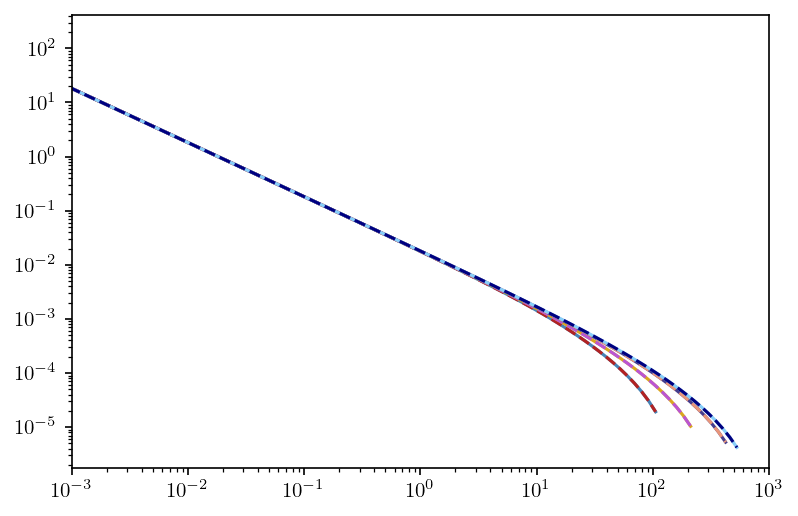

In [41]:
plt.figure(dpi=150)
for gamma, dnde1, dnde2 in zip(gammas, dnde1s, dnde2s):
    emu = gamma * mmu
    es = emu * xs / 2.0
    plt.plot(es, dnde1)
    plt.plot(es, dnde2, ls="--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)

In [16]:
3 * mmu

316.9751235

(1e-06, 1)

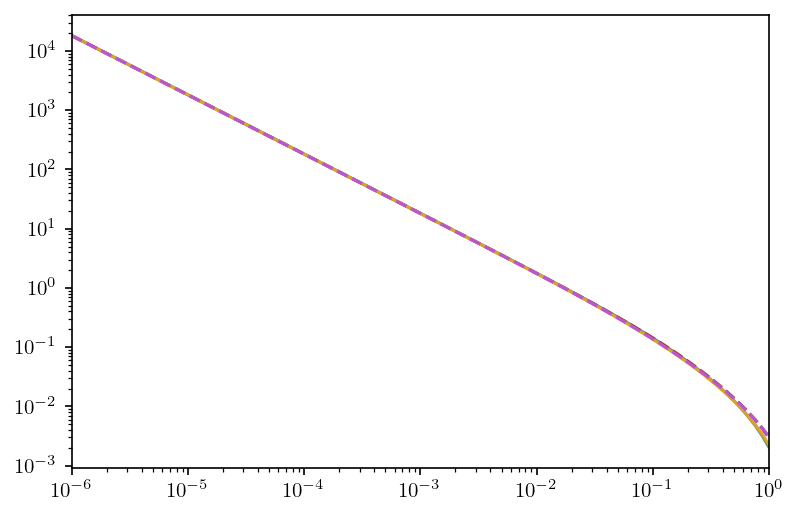

In [37]:
xs = np.geomspace(1e-6, 1.0, 100)

plt.figure(dpi=150)
for gamma in [2.0, 4.0]:
    emu = gamma * mmu
    plt.plot(xs, dndx_photon_muon(xs, emu))
    plt.plot(xs, dndx_photon_muon2(xs, emu), ls="--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-6, 1)

## $\eta$

Branching Fractions:

\begin{align*}
& \mathrm{BR}(\eta \to \gamma + \gamma) = 39.41 \pm 0.20 \% \\
& \mathrm{BR}(\eta \to \pi^0 + \pi^0 + \pi^0) = 32.68 \pm 0.23 \% \\
& \mathrm{BR}(\eta \to \pi^{+} + \pi^{-} + \pi^{0}) = (22.92 \pm 0.28) \% \\
& \mathrm{BR}(\eta \to \pi^{+} + \pi^{-} + \gamma) = ( 4.22 \pm 0.08) \% \\
& \mathrm{BR}(\eta \to e^{-} + e^{+} + \gamma) = ( 6.9 \pm 0.4 )\times 10^{-3} \\
& \mathrm{BR}(\eta \to \mu^{-} + \mu^{+} + \gamma) = ( 3.1 \pm 0.4 )\times 10^{-4} \\
& \mathrm{BR}(\eta \to \pi^{+} + \pi^{-} + e^{-} + e^{+})  = ( 2.68 \pm 0.11)\times 10^{-4} \\
& \mathrm{BR}(\eta \to \pi^0 + \gamma + \gamma) = (2.56 \pm 0.22) \times 10^{-4} \\
& \mathrm{BR}(\eta \to e^{-} + e^{+} + e^{-} + e^{+}) = ( 2.40 \pm 0.22)\times 10^{-5}\\
& \mathrm{BR}(\eta \to \mu^{-} + \mu^{+}) = ( 5.8 \pm 0.8 )\times 10^{-6} 
\end{align*}

In [40]:
BR_ETA_TO_A_A =39.41e-2 
BR_ETA_TO_PI0_PI0_PI0 =32.68e-2 
BR_ETA_TO_PI_PI_PI0 =22.92e-2 
BR_ETA_TO_PI_PI_A =4.22e-2 

def make_energy_hist_pi0_pi0_pi0(cme, nbins, logspace=False, nevents=10000):
    ms = np.array([mpi0, mpi0, mpi0])
    space = generate_phase_space(ms, meta, num_ps_pts=nevents)

    e1s = space[:, 0]
    e2s = space[:, 4]
    e3s = space[:, 8]
    ws = space[:, -1]

    emin = mpi0
    emax = (cme**2 - 3*mpi0**2) / (2*cme)

    if logspace:
        bins = np.geomspace(emin, emax, nbins)
    else:
        bins = np.linspace(emin, emax, nbins)

    ehist1 = np.histogram(e1s, bins=bins, weights=ws, density=True)
    ehist2 = np.histogram(e1s, bins=bins, weights=ws, density=True)
    ehist3 = np.histogram(e1s, bins=bins, weights=ws, density=True)

    return (ehist1, ehist2, ehist3)

def make_spectrum_pi0_pi0_pi0(egams, cme, nbins):
    hists = make_energy_hist_pi0_pi0_pi0(cme, nbins)

    dnde = np.zeros_like(egams)
    for hist in hists:
        for p, e in zip(*hist):
            dnde = dnde + p * dnde_photon_pi0(egams, e)
    return dnde


def make_energy_hist_pi_pi_pi0(cme, nbins, logspace=False):
    ms = np.array([mpi, mpi, mpi0])
    space = generate_phase_space(ms, meta)

    e1s = space[:, 0]
    e2s = space[:, 4]
    e3s = space[:, 8]
    ws = space[:, -1]

    emins = [mpi, mpi, mpi0]
    emaxs = [(m**2 - m2**2 - 2*m2*m3-m3**2 + cme**2) / (2*cme) 
            for (m, m2, m3) in zip([mpi, mpi, mpi0], [mpi, mpi, mpi], [mpi0, mpi0, mpi])]

    if logspace:
        bins = [np.geomspace(emin, emax, nbins) for emin, emax in zip(emins, emaxs)]
    else:
        bins = [np.linspace(emin, emax, nbins) for emin, emax in zip(emins, emaxs)]

    ehist1 = np.histogram(e1s, bins=bins[0], weights=ws, density=True)
    ehist2 = np.histogram(e1s, bins=bins[1], weights=ws, density=True)
    ehist3 = np.histogram(e1s, bins=bins[2], weights=ws, density=True)

    return (ehist1, ehist2, ehist3)

def make_spectrum_pi_pi_pi0(egams, cme, nbins):
    hists = make_energy_hist_pi_pi_pi0(cme, nbins)

    dnde = np.zeros_like(egams)
    for f, hist in zip([dnde_photon_pi,dnde_photon_pi,dnde_photon_pi0], hists):
        for p, e in zip(*hist):
            dnde = dnde + p * f(egams, e)
    return dnde


def make_spectrum_eta(egams):
    pi_pi_pi0 = BR_ETA_TO_PI_PI_PI0 * make_spectrum_pi_pi_pi0(egams, meta, 50)
    pi0_pi0_pi0 = BR_ETA_TO_PI0_PI0_PI0 * make_spectrum_pi0_pi0_pi0(egams, meta, 50)
    line = SpectrumLine(meta / 2.0, BR_ETA_TO_A_A)

    return Spectrum(egams, pi0_pi0_pi0 + pi_pi_pi0, lines = line)

In [41]:
emax = (meta**2 - 3*mpi0**2) / (2*meta)
egams = np.geomspace(1e-6, emax, 250)

dnde_photon_eta = make_spectrum_eta(egams)

/home/logan/github/Hazma/hazma/decay.py:207: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.charged_pion_decay_spectrum(


(0.001, 500.0)

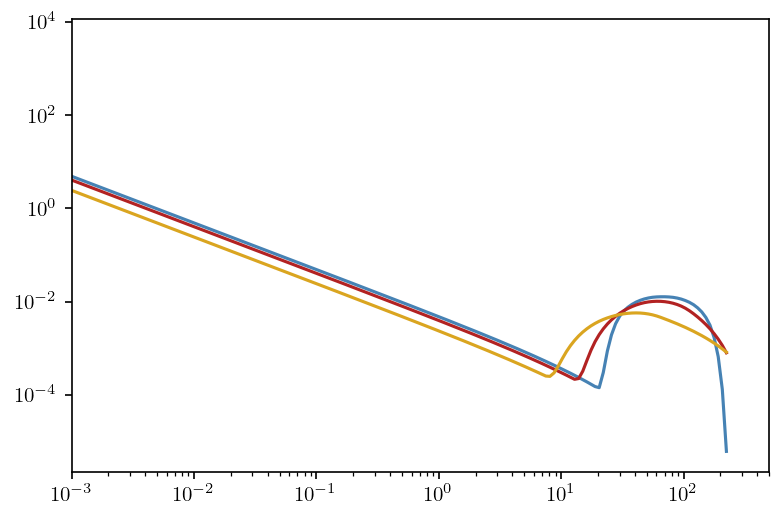

In [46]:
plt.figure(dpi=150)

for beta in [0.1, 0.5, 0.8]:
    boosted = dnde_photon_eta.boost(beta)
    plt.plot(boosted.es, boosted.dndes)
#plt.plot(egams, dnde_eta_to_pi_pi_pi0)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 500.0)

In [47]:
from hazma.vector_mediator.form_factors.pi_k_kstar import FormFactorPi0K0K0

## $\omega$

## $\phi$